In [1]:
# from adnmtf import NMF, NTF
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as image
import sys
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.model_selection import train_test_split

from adnmtf import NMF
import adilsm.adilsm as ilsm

DATA_PATH = r'C:\Users\paul_\OneDrive\Pro\Galderma\Vevey\NEMO Phase 3\AD\EASI\data'
RESULTS_PATH = r'C:\Users\paul_\OneDrive\Pro\Galderma\Vevey\NEMO Phase 3\AD\EASI\results\ISM'

adilsm version=0.0.12


Data prep

In [2]:
def percent_Y_by_treatment(df):
    filtered_df = df[df['CRIT1FL'] == 'Y']
    # Group by 'TREAT' and calculate the percentage
    result_df = filtered_df.groupby('TRTP').size() / df.groupby('TRTP').size() * 100   
    result_df = result_df.reset_index(name='Percentage')
    nemo_Y = result_df['Percentage'][0]
    placebo_Y = result_df['Percentage'][1]
    return nemo_Y, placebo_Y

df = pd.read_csv(DATA_PATH + r'\adeasi3_by_zone.csv', na_values=' ', index_col='USUBJID')
df_easy_resp_w16 = pd.read_csv(DATA_PATH + r'\easi_resp_w16.csv', na_values=' ', index_col='USUBJID')
df = pd.merge(df_easy_resp_w16, df, on='USUBJID', how='right')

nemo_Y_0, placebo_Y_0 = percent_Y_by_treatment(df)
seuil_diff = .5
test_size = 0.20
test_size = 0
add_lab_views = False

# i_trial = 0 # ***
# i_trial = 199
i_trial = 239 # ******
# i_trial = 293
# i_trial = 325
# i_trial = 407
# i_trial = 708
# i_trial = 765 # *****
# i_trial = 835
# i_trial = 1181 # **
# i_trial = 1185
# i_trial = 1225

if test_size > 0:
    while i_trial < 2000:
        df_train, df_val = train_test_split(df, test_size=test_size, random_state=i_trial)

        nemo_Y_1, placebo_Y_1 = percent_Y_by_treatment(df_train)
        nemo_Y_2, placebo_Y_2 = percent_Y_by_treatment(df_val)

        diff_nemo_Y_1 = abs(nemo_Y_1 - nemo_Y_0)
        diff_nemo_Y_2 = abs(nemo_Y_2 - nemo_Y_0)
        diff_placebo_Y_1 = abs(placebo_Y_1 - placebo_Y_0)
        diff_placebo_Y_2 = abs(placebo_Y_2 - placebo_Y_0)

        if diff_nemo_Y_1 < seuil_diff and diff_nemo_Y_2 < seuil_diff and \
            diff_placebo_Y_1 < seuil_diff and diff_placebo_Y_2 < seuil_diff:
            print(i_trial, nemo_Y_0, nemo_Y_1, nemo_Y_2)
            print(i_trial, placebo_Y_0, placebo_Y_1, placebo_Y_2)
            break    
        else:
            i_trial +=1

    df = df_train

m0 = df.values[:,4:].astype(np.float_)
n_items = [5, 5, 5, 5]
n_scores = 4
Xs=[m0[:,i*n_items[0]:(i+1)*n_items[0]] for i in range(n_scores)]
list_columns = df.columns[4:].to_list()
score_pref = ['Head And Neck', 'Limb, Lower', 'Limb, Upper', 'Trunk']

if add_lab_views:
    df_blood = pd.read_csv(RESULTS_PATH + r'\ISM lab\csv\blood.csv', na_values=' ', index_col='SUBJID')
    Xs.append(np.empty((0,0)))
    list_columns += df_blood.columns.to_list()

    df_hemato = pd.read_csv(RESULTS_PATH + r'\ISM lab\csv\hematology.csv', na_values=' ', index_col='SUBJID')
    Xs.append(np.empty((0,0)))
    list_columns += df_hemato.columns.to_list()

    n_scores += 2
    score_pref += ['Blood chemistry', 'Hematology']
    n_items += [df_blood.shape[1], df_hemato.shape[1]]


ISM workflow

In [3]:

# Train on EASI views
n_embedding, n_themes = [4,6]

ilsm_result = ilsm.ism(Xs[:4], n_embedding, n_themes, norm_columns=1, update_h_ism=True,
                max_iter_integrate = 20, max_iter_mult=100, fast_mult_rules=False, sparsity_coeff=1)
hv = ilsm_result['HV']
hv_sparse = ilsm_result['HV_SPARSE']
hhii_updated = ilsm_result['HHII']
w4_ism = ilsm_result['W']
h4_ism = ilsm_result['H']
q4_ism = ilsm_result['Q']
Xs_emb = ilsm_result['EMBEDDING']
Xs_norm = ilsm_result['NORMED_VIEWS']

h4_updated = hv[0].copy()
h4_updated_sparse = hv_sparse[0].copy()
for h in hv[1:]:
    h4_updated = np.vstack((h4_updated, h))
for h in hv_sparse[1:]:
    h4_updated_sparse = np.vstack((h4_updated_sparse, h))

tensor_score = Xs_emb[0].copy()
for x in Xs_emb[1:]:
    tensor_score = np.hstack((tensor_score, x))

m0_norm = Xs_norm[0].copy()
for x in Xs_norm[1:]:
    m0_norm = np.hstack((m0_norm, x))

print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(np.linalg.cond(h4_updated), 2))

error ism before straightening:  0.27
error ism after straightening:  0.24
condition number(4, 6) =  2.33


In [4]:
if add_lab_views:
    # Intersect views
    df.reset_index(drop=False, inplace=True)
    df.insert(df.columns.get_loc('USUBJID') + 1, 'SUBJID', df['USUBJID'].str[10:])
    df = pd.concat([df.iloc[:, :6], pd.DataFrame(w4_ism, 
            columns=['w4_ism_{}'.format(i+1) for i in range(w4_ism.shape[1])]), df.iloc[:, 6:]], axis=1)
    df.set_index('USUBJID', inplace=True)
    df = df.merge(df_blood, left_on='SUBJID', right_on='SUBJID')
    df = df.merge(df_hemato, left_on='SUBJID', right_on='SUBJID')
    # import xlwings as xw
    # xw.sheets.active.range("A1").value = df

    m0 = df.values[:,n_themes+5:].astype(np.float_)
    # initialize view-mapping mask
    h4_updated_sparse[h4_updated_sparse != 0] = 1
    h4_updated_sparse = np.vstack((h4_updated_sparse, np.ones((n_items[4]+n_items[5], n_themes))))
    hv_init_mask = []
    i2 = 0
    for i in range(n_scores):
        i1 = i2
        i2 += n_items[i]
        Xs[i] = m0[:,i1:i2]
        hv_init_mask.append(h4_updated_sparse[i1:i2,:])

    w4_ism = df.values[:,5:n_themes+5].astype(np.float_)

        # Extend views 
    n_embedding, n_themes = [6,6]

    ilsm_result = ilsm.ism(Xs, n_embedding, n_themes, norm_columns=2, w_ism=w4_ism, update_w_ism=False,
                    hv_init_mask=hv_init_mask, update_h_ism=False, max_iter_integrate = 5, max_iter_mult=100,
                    fast_mult_rules=False, sparsity_coeff=1)
    hv = ilsm_result['HV']
    hv_sparse = ilsm_result['HV_SPARSE']
    hhii_updated = ilsm_result['HHII']
    w4_ism = ilsm_result['W']
    h4_ism = ilsm_result['H']
    q4_ism = ilsm_result['Q']
    Xs_emb = ilsm_result['EMBEDDING']
    Xs_norm = ilsm_result['NORMED_VIEWS']

    h4_updated = hv[0].copy()
    h4_updated_sparse = hv_sparse[0].copy()
    for h in hv[1:]:
        h4_updated = np.vstack((h4_updated, h))
    for h in hv_sparse[1:]:
        h4_updated_sparse = np.vstack((h4_updated_sparse, h))

    tensor_score = Xs_emb[0].copy()
    for x in Xs_emb[1:]:
        tensor_score = np.hstack((tensor_score, x))

    m0_norm = Xs_norm[0].copy()
    for x in Xs_norm[1:]:
        m0_norm = np.hstack((m0_norm, x))

    print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(np.linalg.cond(h4_updated), 2))


Save ISM results

In [5]:
# Save
def calculate_value(row):
    for i in range(1, n_themes+1):
        if row.iloc[n_themes] == i:
            return row.iloc[i-1]

df_h4_updated = ilsm.format_loadings(h4_updated_sparse, list_columns)
df_h4_updated.to_csv(RESULTS_PATH + r'\h4_updated.csv', sep=',', na_rep='.', index=True)

h4_updated_sparse = normalize(h4_updated_sparse, axis=0, norm='l2')
df_h4_updated_sparse = ilsm.format_loadings(h4_updated_sparse, list_columns)
df_h4_updated_sparse = df_h4_updated_sparse.set_index(['label'])
cluster = np.argmax(df_h4_updated_sparse.iloc[:,:n_themes], axis=1)+1
df_h4_updated_sparse.insert(loc=n_themes, column='nmf_cluster', value=cluster)
df_h4_updated_sparse['nmf_cluster'] = cluster
df_h4_updated_sparse['nmf_cluster_loading'] = df_h4_updated_sparse.apply(lambda row: calculate_value(row), axis=1)
df_h4_updated_sparse.reset_index(drop=False, inplace=True)
df_h4_updated_sparse.to_csv(RESULTS_PATH + r'\h4_updated_sparse.csv', sep=',', na_rep='.', index=True)

df_q4_ism = pd.DataFrame(q4_ism)
df_q4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)]
df_q4_ism.insert(loc=0, column='score', value=score_pref)
df_q4_ism.to_csv(RESULTS_PATH + r'\q4_ism.csv', sep=',', na_rep='.', index=True)

cluster = np.argmax(w4_ism, axis=1)+1
# cluster = np.argmax(normalize(w4_ism, norm='max', axis=0), axis=1)+1

calinski_harabasz_score = metrics.calinski_harabasz_score(w4_ism, cluster)
print(f'calinski_harabasz_score: {calinski_harabasz_score}')
silhouette_score = metrics.silhouette_score(w4_ism, cluster, metric='euclidean')
print(f'Silhouette Score: {silhouette_score}')

df_w4_ism = pd.DataFrame(np.column_stack((w4_ism, cluster)))
df_w4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)] + ['nmf_cluster']

# Apply the function to each row
df_w4_ism['nmf_cluster_loading'] = df_w4_ism.apply(lambda row: calculate_value(row), axis=1)

for k in range(1,7):
    df_w4_ism['pred_'+str(k)] = df_w4_ism['theme_'+str(k)] / df_w4_ism[['theme_' +str(i) for i in range(1,6) if i != k]].max(axis=1)

df_w4_ism.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)] + ['nmf_cluster', 'nmf_cluster_loading'] +  ['pred_' + str(i) for i in range(1, n_themes + 1)]

df_w4_ism.insert(0, 'TRTP', df['TRTP'].to_list())
df_w4_ism.insert(0, 'ASEX', df['ASEX'].to_list())
df_w4_ism.insert(0, 'AGEGR1', df['AGEGR1'].to_list())
df_w4_ism.insert(0, 'CRIT1FL', df['CRIT1FL'].to_list())
df_w4_ism.insert(loc=0, column='USUBJID', value=(df.index.to_list()))
df_w4_ism.set_index('USUBJID', inplace=True)
df_w4_ism_no_na = df_w4_ism.dropna(subset=['CRIT1FL'], inplace=False)
df_w4_ism_no_na = df_w4_ism_no_na.sort_values(by=['nmf_cluster', 'nmf_cluster_loading'], ascending=[True, False])
df_w4_ism_no_na.to_csv(RESULTS_PATH + r'\w4_ism.csv', sep=',', na_rep='.',index=True)

df_norm = pd.DataFrame(m0_norm)
df_norm.columns = list_columns
df_norm.insert(0, 'TRTP', df['TRTP'].to_list())
df_norm.insert(0, 'ASEX', df['ASEX'].to_list())
df_norm.insert(0, 'AGEGR1', df['AGEGR1'].to_list())
df_norm.insert(0, 'CRIT1FL', df['CRIT1FL'].to_list())
df_norm.insert(loc=0, column='USUBJID', value=(df.index.to_list()))
df_norm.set_index('USUBJID', inplace=True)
df_norm.insert(0, 'nmf_cluster_loading', df_w4_ism['nmf_cluster_loading'].to_list())
df_norm.insert(0, 'nmf_cluster', df_w4_ism['nmf_cluster'].to_list())
df_norm = df_norm.sort_values(by=['nmf_cluster', 'nmf_cluster_loading'], ascending=[True, False])
df_norm.to_csv(RESULTS_PATH + r'\ISM lab\csv\easi_lab_norm.csv', sep=',', na_rep='.',index=True)
calinski_harabasz_score = metrics.calinski_harabasz_score(m0_norm, cluster)
print(f'calinski_harabasz_score: {calinski_harabasz_score}')
silhouette_score = metrics.silhouette_score(m0_norm, cluster, metric='euclidean')
print(f'Silhouette Score: {silhouette_score}')

# Save the tensor
df_tensor_score = pd.DataFrame(data=tensor_score)
df_tensor_score.columns = [score_pref[j] + ':theme_' + str(i) for j in range(len(score_pref)) for i in range(1, int(tensor_score.shape[1]/n_scores) + 1)]
df_tensor_score.insert(loc=0, column='wise_id', value=(df.index.to_list()))
df_tensor_score.set_index('wise_id', inplace=True)
df_tensor_score.to_csv(RESULTS_PATH + r'\tensor_score.csv', sep=',', na_rep='.', index=True)

calinski_harabasz_score: 217.20840085533604
Silhouette Score: 0.09876481301254425


calinski_harabasz_score: 83.19496755956924
Silhouette Score: 0.03126058448014593


In [6]:
if test_size > 0:
    # Predict 
    m02b = df_val.values[:,4:].astype(np.float_)
    m02b_nan_0 = m02b.copy()

    # Prediction using standard NMF
    # # create m0_weight with ones and zeros if not_missing/missing value
    # m02b_weight = np.where(np.isnan(m02b), 0, 1)
    # m02b_nan_0[np.isnan(m02b_nan_0)]=0

    # max_values = np.max(m02b_nan_0, axis=0)
    # # Replace maximum values equal to 0 with 1
    # m02b = np.divide(m02b, np.where(max_values == 0, 1, max_values))
    # m02b_nan_0 = np.divide(m02b_nan_0, np.where(max_values == 0, 1, max_values))

    # my_nmfmodel = NMF(n_components=n_themes, leverage=None, max_iter=200, tol=1.e-6, verbose=-1, random_state=0)
    # estimator_ = my_nmfmodel.fit_transform(m02b.copy(), h=h4_updated_sparse, update_h=False)
    # w42b = estimator_.w
    # h42b = estimator_.h
    # scale = np.linalg.norm(h4_updated_sparse, axis=0) / np.linalg.norm(h42b, axis=0)
    # h42b *= scale
    # w42b /= scale

    Xs2b=[m02b[:,i*n_items[0]:(i+1)*n_items[0]] for i in range(n_scores)]
    ilsm_result = ilsm.ism_predict_w(Xs2b, hv_sparse, h4_ism, q4_ism, n_themes, norm_columns = 1, 
        max_iter_mult=200)

    hv_sparse_new = ilsm_result['HV_SPARSE']
    for i_score in range(n_scores):
        if i_score == 0:
            h_updated_sparse_0 = hv_sparse[0]
            h_updated_sparse = hv_sparse_new[0]
        else:
            h_updated_sparse_0 = np.vstack((h_updated_sparse_0, hv_sparse[i_score]))
            h_updated_sparse = np.vstack((h_updated_sparse, hv_sparse_new[i_score]))

    w42b = ilsm_result['W']


    cluster = np.argmax(w42b, axis=1)+1
    # cluster = np.argmax(normalize(w4_ism, norm='max', axis=0), axis=1)+1

    calinski_harabasz_score = metrics.calinski_harabasz_score(w42b, cluster)
    print(f'calinski_harabasz_score: {calinski_harabasz_score}')

    df_w42b = pd.DataFrame(np.column_stack((w42b, cluster)))
    df_w42b.columns = ['theme_' + str(i) for i in range(1, n_themes + 1)]+ ['nmf_cluster']

    def calculate_value(row):
        for i in range(1, n_themes+1):
            if row.iloc[n_themes] == i:
                return row.iloc[i-1]

    # Apply the function to each row
    df_w42b['nmf_cluster_loading'] = df_w42b.apply(lambda row: calculate_value(row), axis=1)

    for k in range(1,7):
        df_w42b['pred_'+str(k)] = df_w42b['theme_'+str(k)] / df_w42b[['theme_' +str(i) for i in range(1,6) if i != k]].max(axis=1)

    df_w42b.insert(0, 'TRTP', df_val['TRTP'].to_list())
    df_w42b.insert(0, 'ASEX', df_val['ASEX'].to_list())
    df_w42b.insert(0, 'AGEGR1', df_val['AGEGR1'].to_list())
    df_w42b.insert(0, 'CRIT1FL', df_val['CRIT1FL'].to_list())
    df_w42b.insert(loc=0, column='USUBJID', value=(df_val.index.to_list()))
    df_w42b.set_index('USUBJID', inplace=True)
    df_df_w42b_no_na = df_w42b.dropna(subset=['CRIT1FL'], inplace=False)
    df_df_w42b_no_na = df_df_w42b_no_na.sort_values(by=['nmf_cluster', 'nmf_cluster_loading'], ascending=[True, False])
    df_df_w42b_no_na.to_csv(RESULTS_PATH + r'\w42b.csv', sep=',', na_rep='.',index=True)

Figures

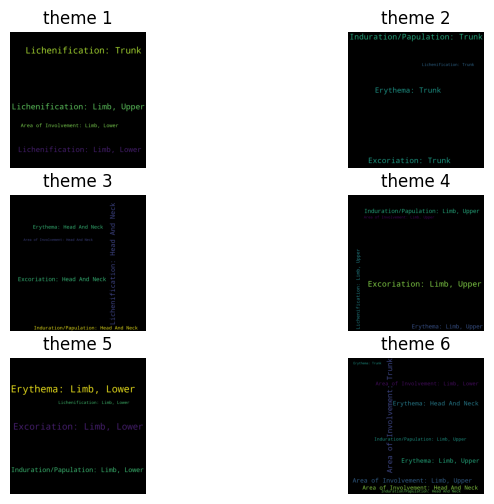

In [7]:
# Plot word clouds of the survey items
ncols = 2
nrows = int(np.ceil(n_themes/ncols))

irow = 0
icol = -1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6))

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated_sparse[df_h4_updated_sparse.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    icol = icol+1
    title = 'theme ' + str(i)
    axes[irow, icol].imshow(wc)
    axes[irow, icol].axis('off')
    axes[irow, icol].set_title(title)
    if icol==ncols-1:
        icol = -1
        irow+=1
 
fig_name=RESULTS_PATH + r'\word_clouds_items.png'
plt.savefig(fig_name, dpi=300)
plt.show()

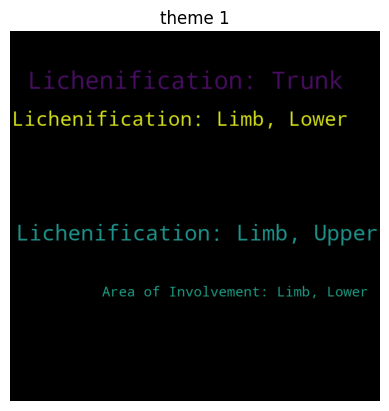

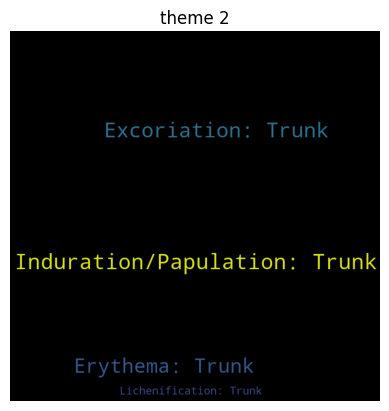

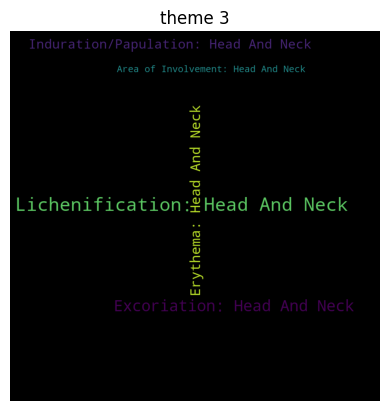

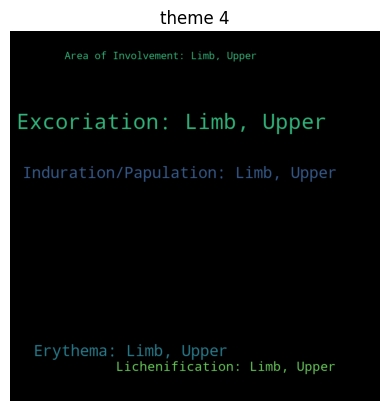

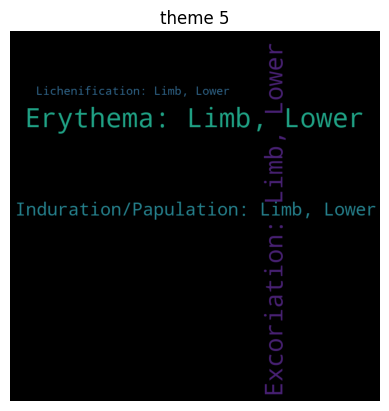

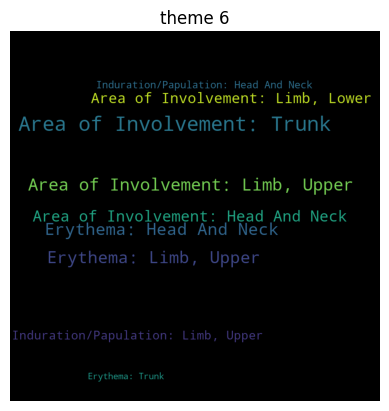

In [8]:
# Plot individual word clouds of the survey items

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated_sparse[df_h4_updated_sparse.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_items_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

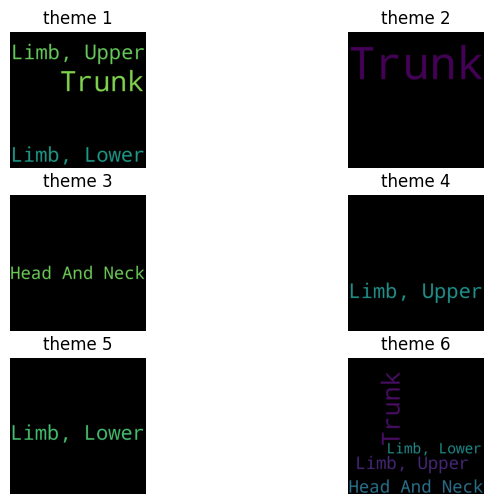

In [9]:
# Plot word clouds of the surveys
ncols = 2
nrows = int(np.ceil(n_themes/ncols))

irow = 0
icol = -1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6))

for i in range(1,n_themes+1):
    sub_df_q4_ism=df_q4_ism[df_q4_ism.columns[[0,i]]].set_index('score').T.to_dict('list')
    for k in sub_df_q4_ism:
        sub_df_q4_ism[k] = sub_df_q4_ism[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_q4_ism)

    icol = icol+1
    title = 'theme ' + str(i)
    axes[irow, icol].imshow(wc)
    axes[irow, icol].axis('off')
    axes[irow, icol].set_title(title)
    if icol==ncols-1:
        icol = -1
        irow+=1
 
fig_name=RESULTS_PATH + r'\word_clouds_surveys.png'
plt.savefig(fig_name, dpi=300)
plt.show()

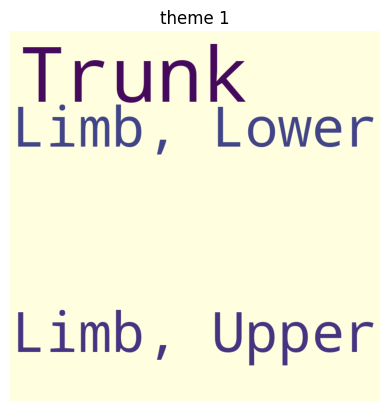

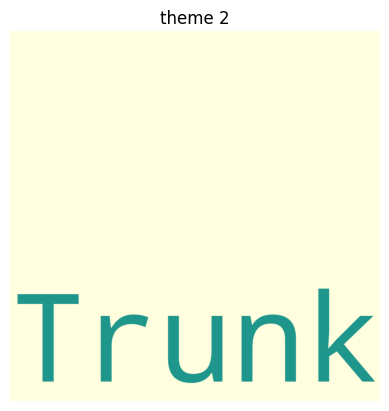

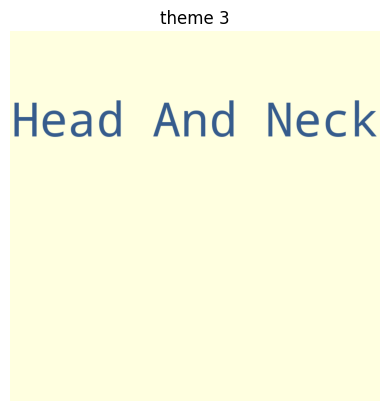

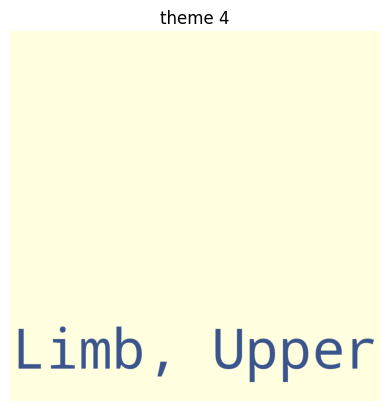

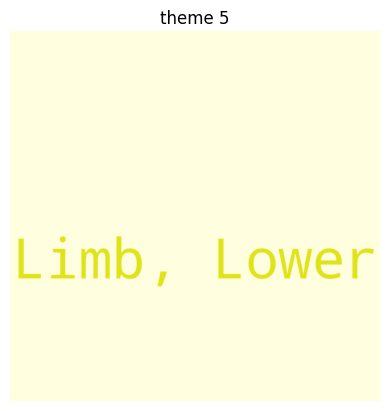

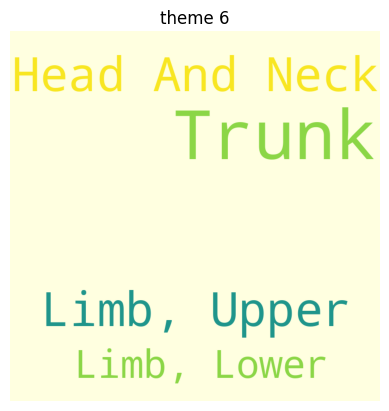

In [10]:
# Plot individual word clouds of the surveys

for i in range(1,n_themes+1):
    sub_df_q4_ism=df_q4_ism[df_q4_ism.columns[[0,i]]].set_index('score').T.to_dict('list')
    for k in sub_df_q4_ism:
        sub_df_q4_ism[k] = sub_df_q4_ism[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightyellow', relative_scaling=1).generate_from_frequencies(sub_df_q4_ism)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_surveys_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

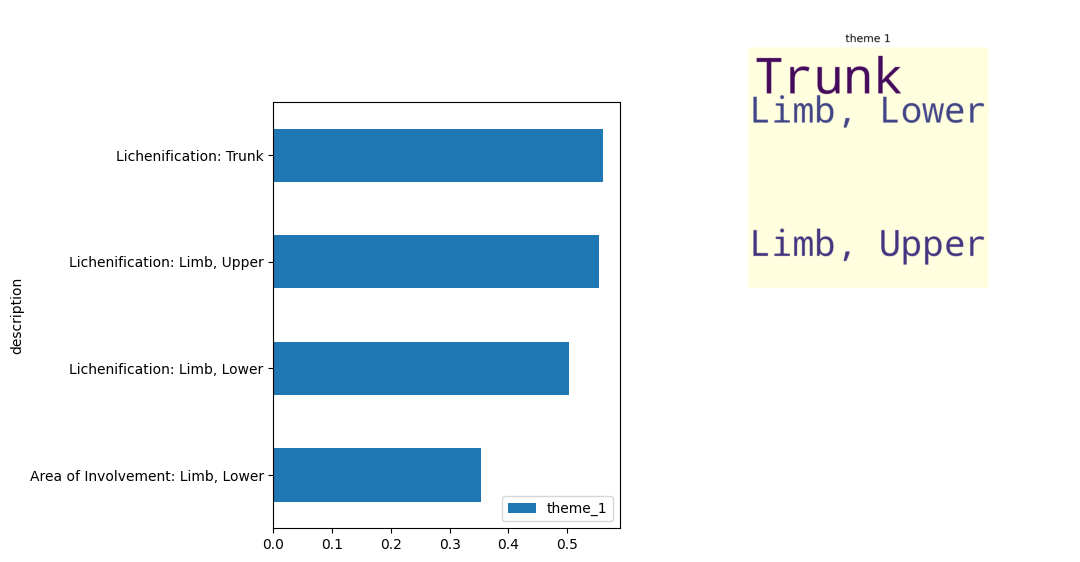

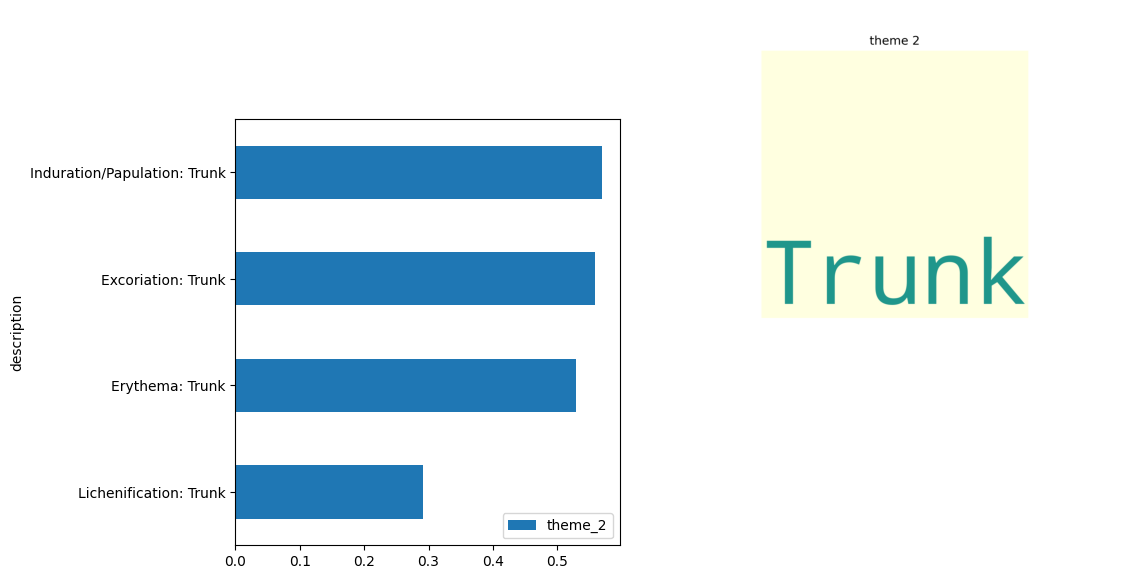

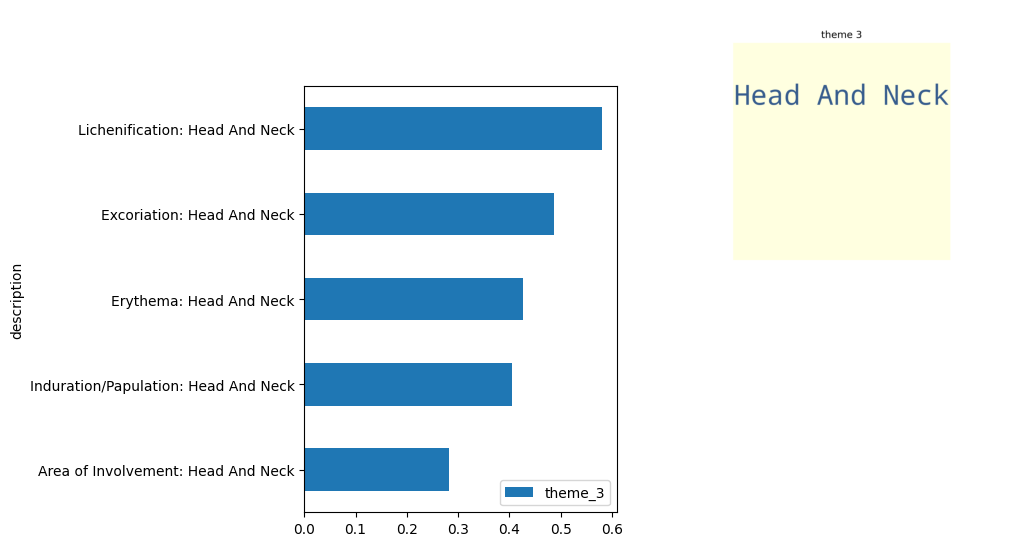

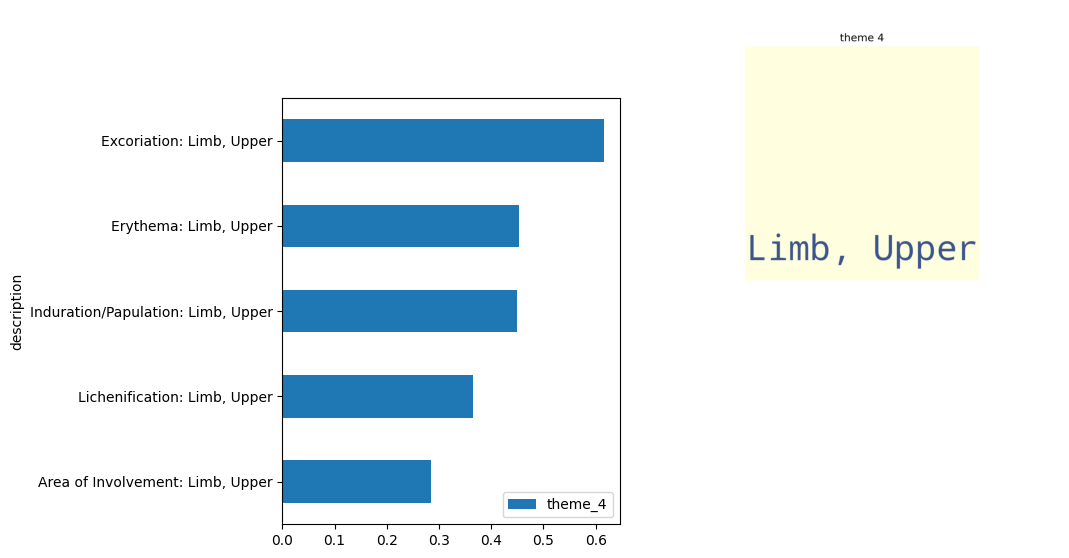

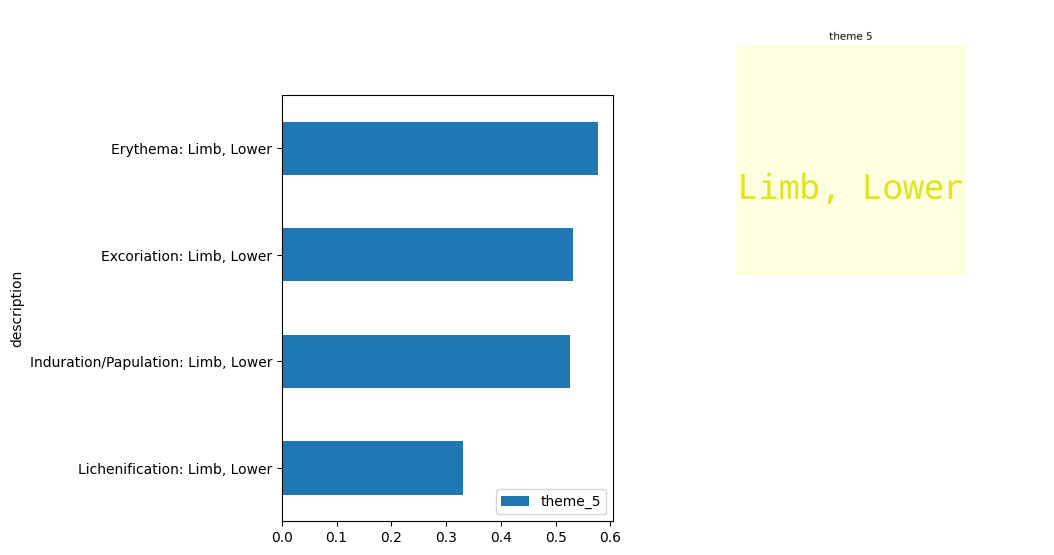

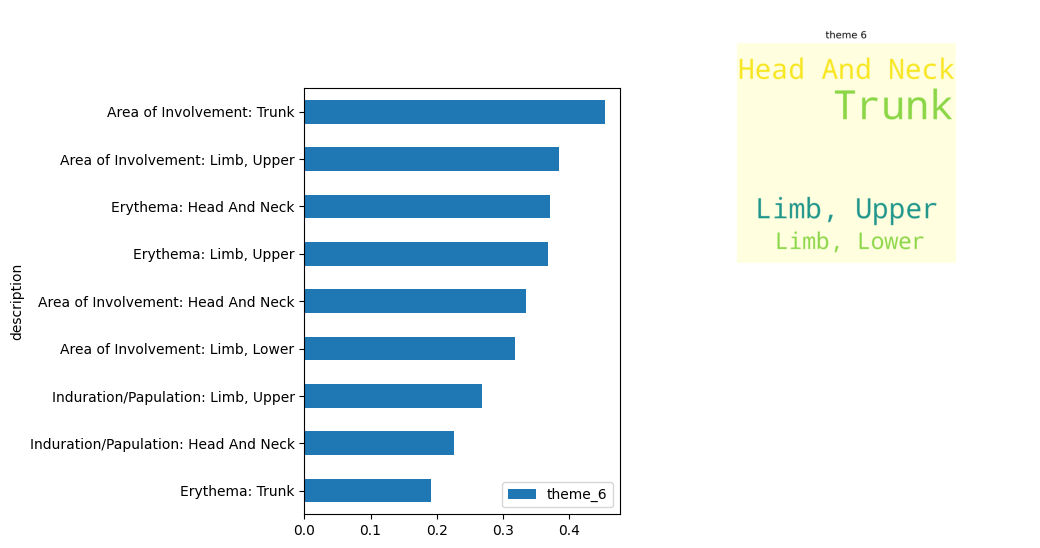

In [11]:
# Plot horizontal bar charts of the themes
for i in range(0,n_themes):
# for i in range(0,1):
    # plot the horizontal bar chart with ordered values
    df_temp = df_h4_updated_sparse[['description','theme_'+str(i+1)]].sort_values(by='theme_'+str(i+1), ascending=False).iloc[0:hhii_updated[i],:]
    df_temp.plot.barh(x='description', y='theme_'+str(i+1))
    fig_name=RESULTS_PATH + r'\theme_' + str(i+1) + '.png'
    plt.tight_layout()
    ax = plt.gca() # get the current axes object
    ax.invert_yaxis() # invert the y-axis
    # fig = plt.gcf()

    # Insert word cloud
    img = image.imread(RESULTS_PATH + r'\word_clouds_surveys_theme '+str(i+1)+'.png')
    # create a new axis for the image
    # ax = plt.gca()
    newax = ax.inset_axes([1.1, 0.25, 1.2, 1.2]) # adjust the position and size of the image
    newax.imshow(img)
    newax.axis("off") # turn off the axis

    plt.savefig(fig_name, dpi=300, bbox_inches="tight")
    plt.show()


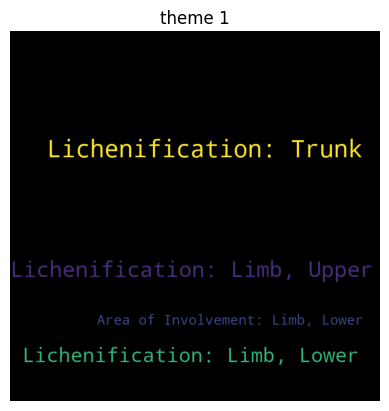

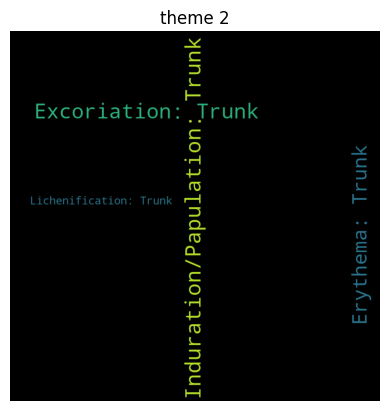

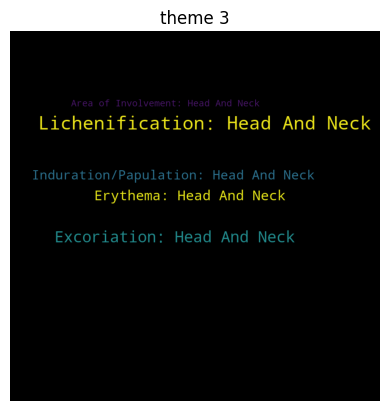

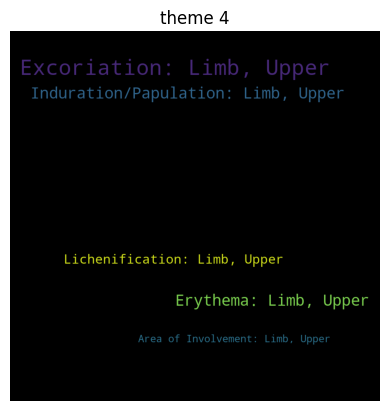

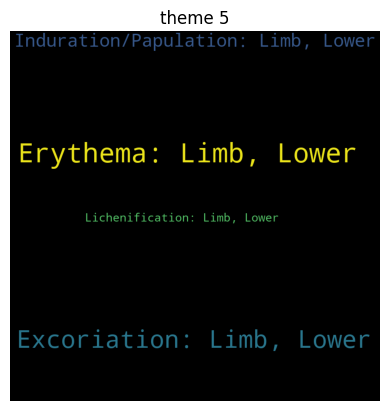

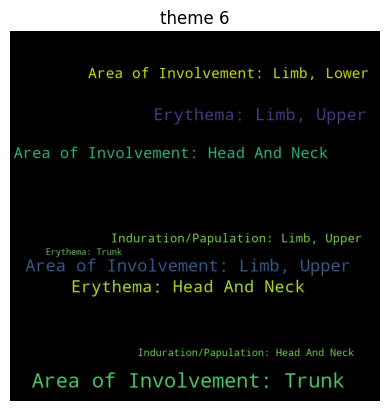

In [12]:
# Plot individual word clouds of the survey items

for i in range(1,n_themes+1):
    sub_df_h4_updated=df_h4_updated[df_h4_updated.columns[[0,i]]].set_index('label').T.to_dict('list')
    for k in sub_df_h4_updated:
        sub_df_h4_updated[k] = sub_df_h4_updated[k][0]

#    wc = WordCloud(width=800, height=800, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df)
    # wc = WordCloud(width=800, height=800, min_font_size=4, background_color='lightgrey', color_func=lambda *args, **kwargs: "dimgrey", relative_scaling=1).generate_from_frequencies(sub_df_h4)
    wc = WordCloud(width=800, height=800, min_font_size=4, relative_scaling=1).generate_from_frequencies(sub_df_h4_updated)

    title = 'theme ' + str(i)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title)
    fig_name=RESULTS_PATH + r'\word_clouds_items_theme '+str(i)+'.png'
    plt.savefig(fig_name, dpi=300)
    plt.show()

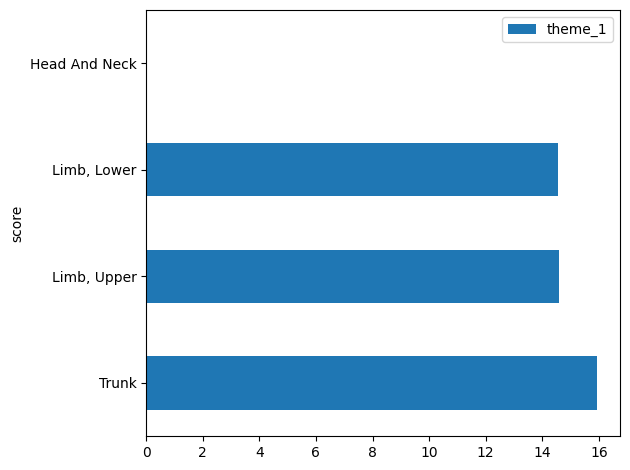

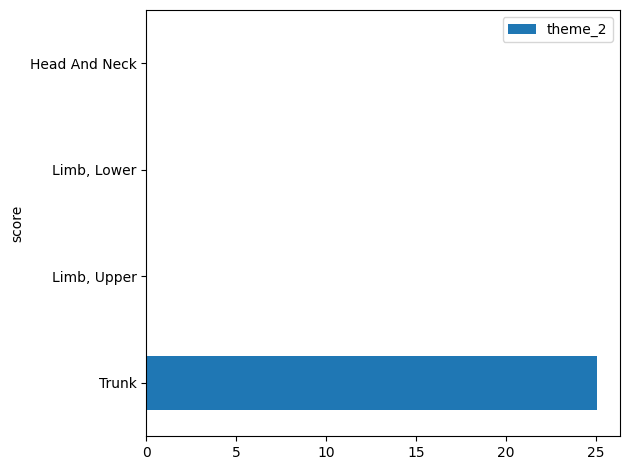

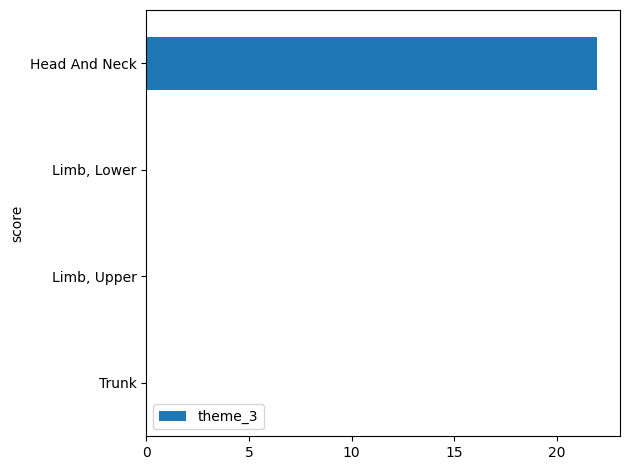

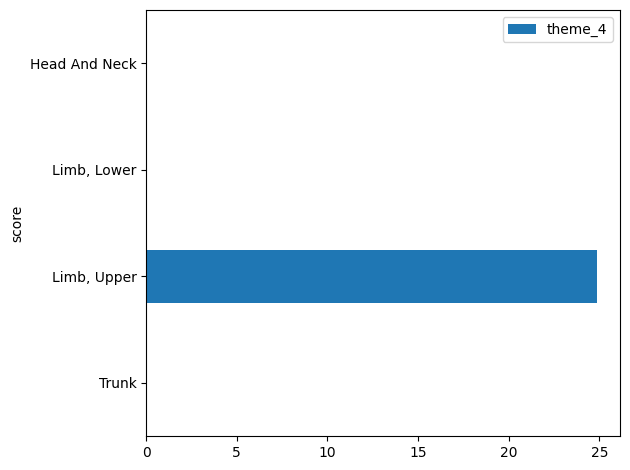

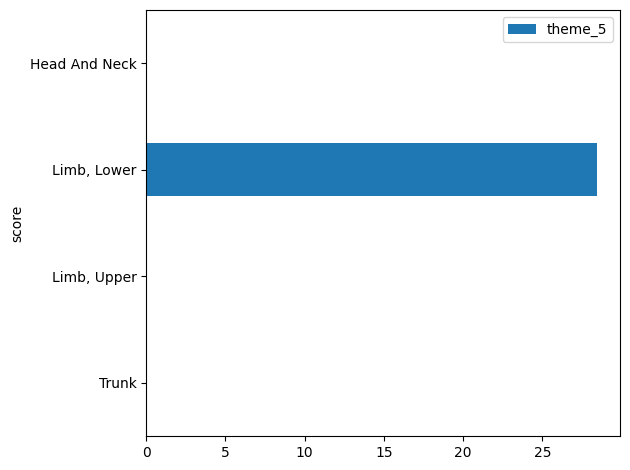

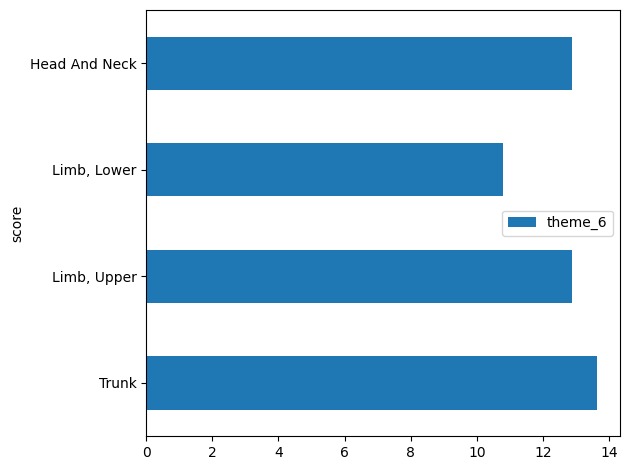

In [13]:
# Plot horizontal bar charts of q4
for i in range(0,n_themes):
    # plot the horizontal bar chart with ordered values
    # df_temp = df_q4[['score','theme_'+str(i+1)]].sort_values(by='theme_'+str(i+1), ascending=False)
    df_temp = df_q4_ism[['score','theme_'+str(i+1)]]
    df_temp.plot.barh(x='score', y='theme_'+str(i+1))
    fig_name=RESULTS_PATH + r'\score_' + str(i+1) + '.png'
    plt.tight_layout()
    ax = plt.gca() # get the current axes object
    ax.invert_yaxis() # invert the y-axis
    # fig = plt.gcf()
    plt.savefig(fig_name, dpi=300)
    plt.show()
